# Activité - Classification de feuilles d'arbres

## Importation des modules Python

In [66]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix

## Traitement du jeu de données

### Importation du jeu de données

In [38]:
#Imporation des données
raw_data = pd.read_csv("E:/Data/RawData/Dataset_feuilles_1.csv")

# Aperçu du jeu de données
snapshot = raw_data.groupby('species').size()
snapshot.head(5)


species
Acer_Capillipes    10
Acer_Circinatum    10
Acer_Mono          10
Acer_Opalus        10
Acer_Palmatum      10
dtype: int64

In [39]:
snapshot.tail(5)

species
Tilia_Tomentosa                 10
Ulmus_Bergmanniana              10
Viburnum_Tinus                  10
Viburnum_x_Rhytidophylloides    10
Zelkova_Serrata                 10
dtype: int64

In [40]:
## On remarque que chaque espèce de feuille comporte un échantillon de 10 individus

### Description des données

In [41]:
snapshot = raw_data.groupby('species').size()
print('Nombre espèces distinctes : {} '.format(len(snapshot)))

Nombre espèces distinctes : 99 


In [42]:
print('Nombre de feuille moyenne par espèces : {} '.format(snapshot.mean()))

Nombre de feuille moyenne par espèces : 10.0 


In [43]:
# Les 99 espèces semblent identiquement distribuées à raison de classes d'effectifs de 10 individus
syntheseFamille = snapshot 
snapshot.head(10)

species
Acer_Capillipes     10
Acer_Circinatum     10
Acer_Mono           10
Acer_Opalus         10
Acer_Palmatum       10
Acer_Pictum         10
Acer_Platanoids     10
Acer_Rubrum         10
Acer_Rufinerve      10
Acer_Saccharinum    10
dtype: int64

In [44]:
## On remarque néanmoins que de nombreuses espèces semblent appartenir à une famille commune
## La dénomination de cette fammille apparaît dans la première partie du titre
# On va donc vérifier que ces famillies sont bien distribuées selon des répartitions équivalentes

In [45]:
# Synthèse par famille
syntheseFamille = snapshot 
# On ne conserve que le premier mot du nom avant le underscore
syntheseFamille.index = syntheseFamille.index.map(lambda x:x[0:x.find('_')])
# On agrège pour obtenir le nombre d'occurences de chaque famille
nombre_famille = len(syntheseFamille.sum(level=0))

ratio_3_premiers = (syntheseFamille.sum(level=0).sort_values(ascending=False)[:3].sum() 
                    /
                    syntheseFamille.sum())

ratio_3_autres = (syntheseFamille.sum(level=0).sort_values(ascending=False)[3:].sum()
                    /
                    syntheseFamille.sum())

print('{} % des observations appartiennent à 3 familles de feuilles.'.
      format(100*np.round(ratio_3_premiers,4)))

print('{} % des observations appartiennent à {} familles de feuilles.'.
      format(100*np.round(ratio_3_autres,4),nombre_famille-3))

53.54 % des observations appartiennent à 3 familles de feuilles.
46.46 % des observations appartiennent à 31 familles de feuilles.


In [46]:
# Il semblerait donc que les familles de feuille ne soient pas distribuées de façon égalitaire
# Plus de la moitié des feuilles de l'échantillon appartiennent à 3 familles de feuilles sur un total de 34 catégories

species
Quercus    380
Acer       100
Alnus       50
Cornus      30
Populus     30
dtype: int64


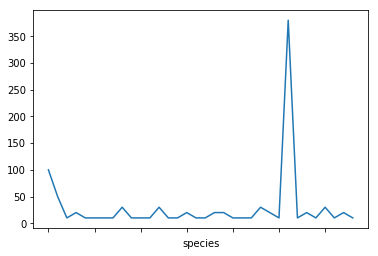

In [47]:
# Affichage des familles de feuille les plus représentées
print(syntheseFamille.sum(level=0).sort_values(ascending=False)[:5])
syntheseFamille.sum(level=0).plot()

In [48]:
# Les 3 catégories Quercus, Acer et Alnus sont sur-représentées par rapport aux autres catégories...
# Il faudra être donc vigilant quant à la composition des données de test et d'apprentissage
# afin que ces jeux de données restent représentatifs de l'ensemble de la population

### Création des jeux de données

#### Encodage des étiquettes de feuilles

In [49]:
#Encodage des données
labelencoder=LabelEncoder()
Espece = raw_data.iloc[:,1]
Proprietes = raw_data.iloc[:,2:raw_data.shape[1]]
especeEncode = labelencoder.fit_transform(Espece)

#### Normalisation du jeu de données

In [50]:
# Normalisaton - Réduction des données
scaler = StandardScaler().fit(Proprietes)
proprietesNR = scaler.transform(Proprietes)

#### Construction des jeux de données de test et d'apprentissage

In [51]:
# Vu les constats sur la sur-représentation de certaines familles de feuilles dans l'échantillon
# On va instaurer un nombre minimal pour l'effectif de chaque classe d'apprentissage afin d'éviter une sous représentation
# En effet, si certaines familles d'espèce sont sous-représentées, il y aura un risque de sous apprentissage
# Ce qui impliquerait une médiocre aptitude à prédire correctement les familles sur lequel le modèle n'aurait pas appris

In [69]:
# Construction des jeux d'entrainement et de test
cluster_inferieur_cinq = True
# On vérifie qu'on ait aucune classe d'effectif inférieur à 5
while (cluster_inferieur_cinq):
    
    Features_train, Features_test, Label_train, Label_test = train_test_split(proprietesNR, 
                                                                              especeEncode, 
                                                                              test_size=0.2)
    distribution_classe = pd.Series(np.ones(Label_train.shape[0]),
                                    index=Label_train)
    cluster_inferieur_cinq = (distribution_classe.sum(level=0).min()  < 5)

print('Effectif minimal dans le jeu d\'entrainement {}'
      .format(distribution_classe.sum(level=0).min()))

Effectif minimal dans le jeu d'entrainement 5.0


In [53]:
# On a fixé un un seuil minimal de 5, en rapport avec les classes d'effectif de 10 individus

## Création de la baseline KNN

In [54]:
# Définiton des paramètres potentiels de la classification des plus proches voisins
parametres_knn = {'n_neighbors': np.arange(1, 10),
                  'metric':["euclidean",
                            "manhattan",
                            "chebyshev",
                            "minkowski"],
                   'weights' : ['uniform',
                                'distance']}

In [55]:
# Recherche par grille des paramètres optimaux de la classification KNN
baseLineKNN = GridSearchCV(
                        estimator=KNeighborsClassifier(),
                        param_grid=parametres_knn,
                        cv=5,
                        scoring='accuracy')   

In [70]:
# Entrainement du modèle KNN 
baseLineKNN.fit(Features_train,
                Label_train)      

print('Les paramètres optimaux pour la base KNN sont les suivants : {}'.
      format(baseLineKNN.best_params_))

Les paramètres optimaux pour la base KNN sont les suivants : {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


## Utlisation d'une SVM avec différents paramètres

### Création d'une SVM basique

In [72]:
# Création d'un classifieur avec les paramètres par défaut de la bibliothèque SKLearn
SVM_Base =LinearSVC()

SVM_Base.fit(Features_train,
             Label_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [60]:
# On remarque qu'on utilise l'option Dual = True dans ce cas, ce qui signifie que l'on va résoudre 
# le problème en mode dual avec cette classification (cas où le nombre de Features est supérieur au nombre d'individus)

### Création d'une SVM multi-classe optimisée

In [61]:
# Création d'un classifieur SVM multi-class avec différents paramètres
parametres_grid_svm = {'multi_class': ['ovr', 
                                       'crammer_singer'],
                       'C': 10**np.linspace(-3,3,num=7),
                       'penalty': ['l1','l2']}

SVM_MultiClass = GridSearchCV(estimator=LinearSVC(dual=False),
                              param_grid=parametres_grid_svm,
                              cv=5,
                              scoring='accuracy')
        
SVM_MultiClass.fit(Features_train,
                   Label_train)                   

print('Les paramètres optimaux pour le SVM multi-classe sont les suivants : {}'.
      format(SVM_MultiClass.best_params_))               

Les paramètres optimaux pour le SVM multi-classe sont les suivants : {'C': 0.1, 'multi_class': 'crammer_singer', 'penalty': 'l1'}


## Evaluation et visualisation des performances des modèles

In [73]:
# Ensemble des modèles comparés
Modeles = {'KNN': baseLineKNN,
           'SVM_Base': SVM_Base,
           'SVM_Multi_Classe': SVM_MultiClass
           }

for title,model in Modeles.items():
    # Calcul des prédictions du modèle
    predictions = model.predict(Features_test)
    c_matr = confusion_matrix(Label_test, predictions)
    
    print(' ' + '-' * 80)
    print('          Performance du modèle {0}'.format(title.upper()))
    print(' ' + '-' * 80)    
    
    # Tableau des erreurs :
    erreur=0
    # En tête du tableau
    print('\nDétail des erreurs :\n\n {0:37s}| {1:37s}| {2:s}'
          .format('Classe réelle (n°)', 
                  'Classe prédite (n°)',
                  'Qté'))
    print(' ' + '-' * 80)
    # Détail des erreurs de prédiction 
    for i in np.arange(0,c_matr.shape[0]):
        if np.sum(c_matr[i, :]):
            for j in np.arange(0,c_matr.shape[1]):
                # Parcours de la matrice de confusion hors diagonale
                if (c_matr[i, j]) & (j!=i):
                    erreur += c_matr[i, j]
                    print(' {0:37s}| {1:37s}| {2:>2d}'                      
                           .format(Espece[i], 
                                   Espece[j], 
                                   c_matr[i, j]))    
                    
    # Revue des performances
    score=(1-accuracy_score(Label_test, predictions))*len(Features_test)
    
    print(' ' + '-' * 80)
    
    print('Score de la prédiction {0} : {1:.2f}%'.
          format(title,
                  100*accuracy_score(Label_test, 
                                             predictions)))
    
    print('--- soit {0} prédictions correctes sur {1}).'.
         format(len(Label_test) - erreur, len(Label_test)))
    
    print('--- soit {0} erreurs de prédicition sur {1}).'.
         format(erreur, len(Label_test)))
    
    print(' ' + '-' * 80)
    print('')
                         

 --------------------------------------------------------------------------------
          Performance du modèle KNN
 --------------------------------------------------------------------------------

Détail des erreurs :

 Classe réelle (n°)                   | Classe prédite (n°)                  | Qté
 --------------------------------------------------------------------------------
 Cytisus_Battandieri                  | Tilia_Tomentosa                      |  1
 Quercus_Canariensis                  | Quercus_Dolicholepis                 |  1
 Quercus_Coccifera                    | Cornus_Controversa                   |  1
 Quercus_Coccifera                    | Celtis_Koraiensis                    |  1
 Quercus_Coccifera                    | Alnus_Maximowiczii                   |  1
 Quercus_Semecarpifolia               | Liquidambar_Styraciflua              |  1
 Quercus_Texana                       | Cornus_Controversa                   |  1
 Acer_Pictum                          

In [62]:
# On constate pour chacun des modèles un nombre d'erreurs relativement raisonnable, 
# d'autant que de nombreuses erreurs se souvent font sur des prédictions de la même famille de feuille

# Ces résultats laissent donc présager de bonnes performances des différents modèles...
# De plus, pour chacun des modèles le score exact de la pertinence de sa classification est plutôt élevé (supérieur à 90%)

## Détermination du meilleur modèle

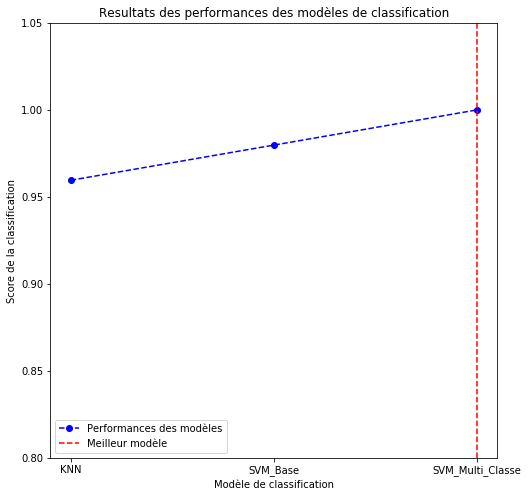

In [74]:
# Détermination du meilleur modèle
Models = []    
Performance = []

for title, model in Modeles.items():
    Models.append(title)
    Performance.append(accuracy_score(Label_test, 
                                 model.predict(Features_test)))
    
visualisation = pd.Series(Performance,index=Models)
AbscisseOptimum = visualisation.idxmax()

# Affichage des résultats sur un graphique en courbe
Titre = 'Resultats des performances des modèles de classification'

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

ax.set_title(Titre)
ax.set_ylim([0.8,1.05])

ax.plot(visualisation.index,visualisation.values,
        'ko--',
        color='blue',
        label = 'Performances des modèles')

ax.plot([AbscisseOptimum, AbscisseOptimum], 
        [0.80, 1.05],
        linestyle='--',
        color='red',
        label='Meilleur modèle')

plt.legend(loc = 'lower left')
plt.ylabel('Score de la classification')
plt.xlabel('Modèle de classification')

plt.show()  

In [ ]:
# Le modèle du SVM multi-classe donne les meilleurs résultats 
# C'est pourquoi,nous faisons le choix de ce modèle !!!

In [75]:
# A noter tout de même, qu'il y a une part de hasard dans la constitution des jeux de test et d'apprentissage
# Le score de 100% du modèle SVM_Multi-classe comporte donc une part d'aléa et n'est pas forcément reproductible
# Si l'ordre de grandeur (au dessus des 96%) est représentatif de la performance du modèle SVM multi-classe 
# La perfection des prédictions (aucune erreur) tient tout de même de l'exception...

## Conclusion

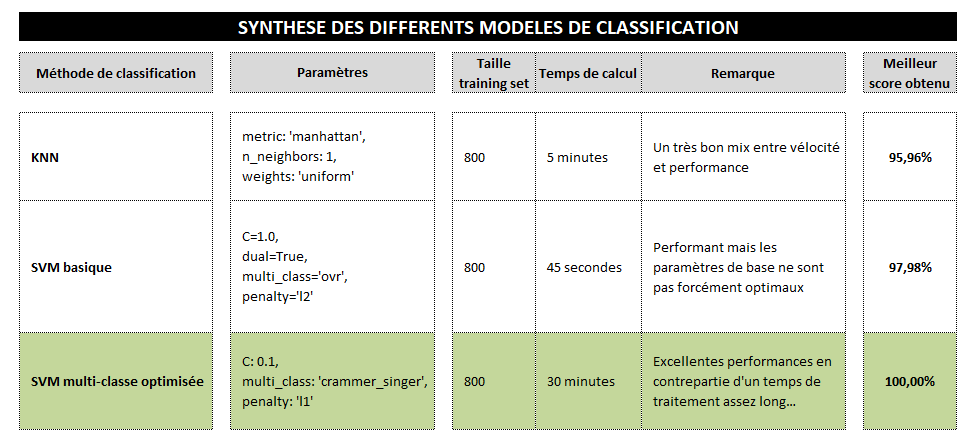

In [76]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "Performances_Modeles.png")

In [77]:
# La revue des performances des modèles linéaires étudiés nous amène à choisir le SVM multi-classe !!
# A noter tout de même, que ces performances sont liés au jeu de données dont les caractéristiques sont très favorables
# aux algorithmes de classification linéaires, ce qui n'est pas toujours le cas...

# Enfin, il convient de nuancer l'excellence des performances du SVM multi-classe au vu des temps de traitement assez longs,
# qui s'avèrerait plus problématique sur des jeux de données plus volumineux (plusieurs millions d'individus)...